# Setup

## Imports

In [3064]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List

In [3065]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [3066]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [3067]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [3068]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [3069]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [3070]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [3071]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [3072]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    output = output.drop(columns=['station', 'station_name'])

    return output

In [3073]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Convert string to datetime(with consideration of leap years, making them all to be in 2024) for future use
    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    # Note)
    # Model might falsely interpret the valuse as ordinal or linear(i.e., it may think Febulary is "twice as big" as Jan!)
    # So we are converting them into sin/cos
    # +) considering our target: the next day's temperature anomaly, therefore we would better to use sin/cos for day of year(doy)!
    # We use both sin/cos -> since we want to uniquely represent any position on a cycle! therefore we need 2D coords

    doy = output['date'].dt.dayofyear
    # Dataset is including the leap year -> so we use the average year length(if other better ideas, please post them at the PR!!)
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)

    # solar declination δ (radians)
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    # hour angle at sunrise ω₀ = arccos(−tanφ⋅tanδ)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    # day length in hours = 2·ω₀·(180/π)/15
    day_len = 2 * ω0 * (180.0/np.pi) / 15.0
    output['day_length'] = day_len
    output['day_frac']   = day_len / 24.0

    output = output.drop(columns=['date', 'lat'])

    return output

In [3074]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}'  for h in range(24)]
    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']
    return output

In [3075]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}"   for i in range(24)]
    if not (set(st_cols) <= set(output.columns) and set(dp_cols) <= set(output.columns)):
        return output

    arr_t  = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = (
            output["surface_temp_avg"] - output["climatology_temp"]
        )

    periods = {
        "night": slice(0,  6),
        "morning": slice(6, 12),
        "afternoon": slice(12,18),
        "evening": slice(18,24),
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d
        output[f"temp_dp_interaction_{name}"] = t * d

    return output

In [3076]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]
    if set(slp_cols).issubset(output.columns):
        output['pressure_tendency'] = output[slp_cols[-1]] - output[slp_cols[0]]
        output['slp_avg'] = output[slp_cols].mean(axis=1)
    return output

In [3077]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6 # For safe division

    # --- Foundational Components (Derived from Parts 1-3 Logic) ---
    # Ensure necessary base columns like 'temp_afternoon_avg', 'temp_morning_avg', etc., exist
    if 'temp_afternoon_avg' in output.columns and 'temp_morning_avg' in output.columns:
        output['diurnal_range_am_pm'] = output['temp_afternoon_avg'] - output['temp_morning_avg']
    if 'temp_evening_avg' in output.columns and 'temp_night_avg' in output.columns:
        output['temp_evening_minus_night_avg'] = output['temp_evening_avg'] - output['temp_night_avg'] # TEMNA
    if 'dew_depression_afternoon' in output.columns and 'dew_depression_morning' in output.columns:
        output['dew_depression_change_day_progress'] = output['dew_depression_afternoon'] - output['dew_depression_morning']

    if 'pressure_tendency' in output.columns and 'doy_sin' in output.columns:
        output['seasonal_pressure_tendency_sin'] = output['pressure_tendency'] * output['doy_sin'] # spts
    if 'pressure_tendency' in output.columns and 'doy_cos' in output.columns:
        output['seasonal_pressure_tendency_cos'] = output['pressure_tendency'] * output['doy_cos'] # sptc

    # Basic Polynomials/Ratios
    if 'slp_avg' in output.columns: output['slp_avg_sq'] = output['slp_avg'] ** 2
    if 'temp_evening_minus_night_avg' in output.columns: output['TEMNA_sq'] = output['temp_evening_minus_night_avg'] ** 2
    if 'pressure_tendency' in output.columns: output['pressure_tendency_sq'] = output['pressure_tendency'] ** 2
    if 'climatology_temp' in output.columns: output['climatology_temp_sq'] = output['climatology_temp'] ** 2 # Consistently good
    if 'surface_temp_anomaly' in output.columns: output['STA_sq'] = output['surface_temp_anomaly'] ** 2 # Keep basic STA poly

    if 'slp_avg' in output.columns and 'pressure_tendency' in output.columns:
        output['ratio_slp_avg_div_pressure_tendency'] = output['slp_avg'] / (output['pressure_tendency'] + epsilon) # Consistently important
    if 'humidity_avg_x_dew_depression_morning' in output.columns and 'humidity_avg_x_dew_depression_evening' in output.columns:
        output['ratio_hum_dew_morn_div_hum_dew_eve'] = output['humidity_avg_x_dew_depression_morning'] / (output['humidity_avg_x_dew_depression_evening'] + epsilon)

    # Helpers for seasonal squares
    if 'doy_sin' in output.columns: output['doy_sin_sq'] = output['doy_sin'] ** 2
    if 'doy_cos' in output.columns: output['doy_cos_sq'] = output['doy_cos'] ** 2


    # --- Core Interactions (Inspired by Parts 4, 5, 6 successes) ---
    # Ensure necessary base cols like humidity_avg, dew_depression_morning/evening exist
    if 'humidity_avg' in output.columns and 'dew_depression_morning' in output.columns:
        output['humidity_avg_x_dew_depression_morning'] = output['humidity_avg'] * output['dew_depression_morning'] # HumDewMorn
    if 'humidity_avg' in output.columns and 'dew_depression_evening' in output.columns:
        output['humidity_avg_x_dew_depression_evening'] = output['humidity_avg'] * output['dew_depression_evening'] # HumDewEve

    if 'climatology_temp' in output.columns:
        if 'doy_sin' in output.columns: output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']
        if 'doy_cos' in output.columns: output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']

    if 'slp_avg' in output.columns and 'day_length' in output.columns:
        output['slp_avg_x_day_length'] = output['slp_avg'] * output['day_length']
        if 'doy_sin' in output.columns: output['slp_daylen_X_doy_sin'] = output['slp_avg_x_day_length'] * output['doy_sin']
        if 'doy_cos' in output.columns: output['slp_daylen_X_doy_cos'] = output['slp_avg_x_day_length'] * output['doy_cos']
        if 'humidity_avg' in output.columns: output['slp_daylen_X_humidity_avg'] = output['slp_avg_x_day_length'] * output['humidity_avg']

    if 'dp_evening_avg' in output.columns:
        if 'doy_sin' in output.columns: output['dp_evening_avg_X_doy_sin'] = output['dp_evening_avg'] * output['doy_sin']
        if 'doy_cos' in output.columns: output['dp_evening_avg_X_doy_cos'] = output['dp_evening_avg'] * output['doy_cos']

    # Critical STA interaction
    if 'surface_temp_anomaly' in output.columns and 'slp_avg' in output.columns:
        output['STA_x_slp_avg'] = output['surface_temp_anomaly'] * output['slp_avg']

    # Pressure tendency interactions
    if 'seasonal_pressure_tendency_sin' in output.columns and 'climatology_temp_x_doy_cos' in output.columns:
        output['spts_X_clim_doy_cos'] = output['seasonal_pressure_tendency_sin'] * output['climatology_temp_x_doy_cos']
    if 'seasonal_pressure_tendency_cos' in output.columns and 'temp_evening_minus_night_avg' in output.columns:
        output['sptc_X_TEMNA'] = output['seasonal_pressure_tendency_cos'] * output['temp_evening_minus_night_avg']
    if 'pressure_tendency_sq' in output.columns and 'temp_evening_minus_night_avg' in output.columns:
        output['pt_sq_X_TEMNA'] = output['pressure_tendency_sq'] * output['temp_evening_minus_night_avg']
    if 'dew_depression_night' in output.columns and 'pressure_tendency' in output.columns:
        output['dew_night_X_pressure_tendency_raw'] = output['dew_depression_night'] * output['pressure_tendency']
    if 'pressure_tendency_sq' in output.columns and 'climatology_temp_x_doy_cos' in output.columns:
        output['pressure_tendency_sq_X_clim_doy_cos'] = output['pressure_tendency_sq'] * output['climatology_temp_x_doy_cos'] # Keep this champion

    if 'diff_clim_doy_sin_cos' not in output.columns and 'climatology_temp_x_doy_sin' in output.columns and 'climatology_temp_x_doy_cos' in output.columns:
        output['diff_clim_doy_sin_cos'] = output['climatology_temp_x_doy_sin'] - output['climatology_temp_x_doy_cos']

    # --- Peak Complexity Patterns (Inspired by Part 7 successes, R² 0.7862) ---

    # A. _X_doy_SQ pattern on selected strong bases
    if 'climatology_temp' in output.columns :
        if 'doy_sin_sq' in output.columns: output['climatology_temp_x_doy_sin_sq'] = output['climatology_temp'] * output['doy_sin_sq']
        if 'doy_cos_sq' in output.columns: output['climatology_temp_x_doy_cos_sq'] = output['climatology_temp'] * output['doy_cos_sq']
    if 'seasonal_pressure_tendency_sin' in output.columns and 'doy_cos_sq' in output.columns:
        output['spts_X_doy_cos_sq'] = output['seasonal_pressure_tendency_sin'] * output['doy_cos_sq']
    if 'diff_clim_doy_sin_cos' in output.columns :
        if 'doy_cos_sq' in output.columns: output['diff_clim_doy_sin_cos_X_doy_cos_sq'] = output['diff_clim_doy_sin_cos'] * output['doy_cos_sq']
        if 'doy_sin_sq' in output.columns: output['diff_clim_doy_sin_cos_X_doy_sin_sq'] = output['diff_clim_doy_sin_cos'] * output['doy_sin_sq']
    if 'pressure_tendency_sq' in output.columns and 'climatology_temp' in output.columns and 'doy_sin_sq' in output.columns:
        output['pt_sq_X_clim_X_doy_sin_sq'] = output['pressure_tendency_sq'] * output['climatology_temp'] * output['doy_sin_sq']

    # Apply to temp_dp_interaction for evening/morning
    for period in ['evening', 'morning']:
        if f'temp_dp_interaction_{period}' in output.columns:
            if 'doy_sin_sq' in output.columns: output[f'temp_dp_interaction_{period}_X_doy_sin_sq'] = output[f'temp_dp_interaction_{period}'] * output['doy_sin_sq']
            if 'doy_cos_sq' in output.columns: output[f'temp_dp_interaction_{period}_X_doy_cos_sq'] = output[f'temp_dp_interaction_{period}'] * output['doy_cos_sq']

    # Apply to STA_x_slp_avg
    if 'STA_x_slp_avg' in output.columns:
        if 'doy_sin_sq' in output.columns: output['STA_x_slp_X_doy_sin_sq'] = output['STA_x_slp_avg'] * output['doy_sin_sq']
        if 'doy_cos_sq' in output.columns: output['STA_x_slp_X_doy_cos_sq'] = output['STA_x_slp_avg'] * output['doy_cos_sq']

    # Apply to Raw STA
    if 'surface_temp_anomaly' in output.columns:
        if 'doy_sin_sq' in output.columns: output['STA_raw_X_doy_sin_sq'] = output['surface_temp_anomaly'] * output['doy_sin_sq']
        if 'doy_cos_sq' in output.columns: output['STA_raw_X_doy_cos_sq'] = output['surface_temp_anomaly'] * output['doy_cos_sq']


    # B. High-Order Interaction ((Derived_A * slp_avg) * Seasonal_C/SQ_C)
    # Reintroduce the R2 champion from 0.7862 run
    if 'climatology_temp_x_doy_sin' in output.columns and 'slp_avg' in output.columns and 'doy_cos' in output.columns:
        output['clim_doy_sin_X_slp_avg_base'] = output['climatology_temp_x_doy_sin'] * output['slp_avg']
        output['clim_doy_sin_slp_X_doy_cos'] = output['clim_doy_sin_X_slp_avg_base'] * output['doy_cos']
    # Maybe one more based on dp_evening_avg
    if 'dp_evening_avg_X_doy_cos' in output.columns and 'slp_avg' in output.columns and 'doy_sin_sq' in output.columns:
        output['dp_eve_doy_cos_X_slp_avg_base'] = output['dp_evening_avg_X_doy_cos'] * output['slp_avg']
        output['dp_eve_doy_cos_slp_X_doy_sin_sq'] = output['dp_eve_doy_cos_X_slp_avg_base'] * output['doy_sin_sq']


    # C. Nuanced STA Interactions (Interacting STA with strong derived features)
    if 'surface_temp_anomaly' in output.columns:
        if 'pressure_tendency_sq_X_clim_doy_cos' in output.columns:
            output['STA_X_pt_sq_clim_doy_cos'] = output['surface_temp_anomaly'] * output['pressure_tendency_sq_X_clim_doy_cos']
        if 'ratio_slp_avg_div_pressure_tendency' in output.columns: # base ratio
            output['ratio_slp_div_pt_X_STA'] = output['ratio_slp_avg_div_pressure_tendency'] * output['surface_temp_anomaly'] # Recreate base for successful_STA_ratio_X_doy_sin
            if 'doy_sin' in output.columns: output['successful_STA_ratio_X_doy_sin'] = output['ratio_slp_div_pt_X_STA'] * output['doy_sin']
        if 'dp_evening_avg_X_doy_sin' in output.columns:
            output['STA_x_dp_evening_doy_sin'] = output['surface_temp_anomaly'] * output['dp_evening_avg_X_doy_sin']

    # D. Ratio Interactions (Interacting base ratios with strong patterns)
    if 'ratio_slp_avg_div_pressure_tendency' in output.columns:
        if 'climatology_temp_x_doy_sin_sq' in output.columns:
            output['base_ratio_slp_pt_X_clim_temp_doy_sin_sq'] = output['ratio_slp_avg_div_pressure_tendency'] * output['climatology_temp_x_doy_sin_sq']
        if 'climatology_temp_x_doy_cos_sq' in output.columns:
            output['base_ratio_slp_pt_X_clim_temp_doy_cos_sq'] = output['ratio_slp_avg_div_pressure_tendency'] * output['climatology_temp_x_doy_cos_sq']

    # --- Selective Additions from Post-Peak Analysis ---

    # E. Add elev_X_slp_avg (simple, high split importance recently)
    if 'elev' in output.columns and 'slp_avg' in output.columns:
        output['elev_X_slp_avg'] = output['elev'] * output['slp_avg']

    # F. Add dp_evening_avg_X_humidity_avg (simple, high SHAP importance recently)
    if 'dp_evening_avg' in output.columns and 'humidity_avg' in output.columns:
        output['dp_evening_avg_X_humidity_avg'] = output['dp_evening_avg'] * output['humidity_avg']

    # G. Add Interaction of the two features above (E x F - experimental but simple)
    # if 'elev_X_slp_avg' in output.columns and 'dp_evening_avg_X_humidity_avg' in output.columns:
    #      output['elev_slp_X_dp_eve_hum'] = output['elev_X_slp_avg'] * output['dp_evening_avg_X_humidity_avg']

    # H. Add the other strong SHAP feature from the failed runs: elev_slp_avg_X_STA_slp_avg
    if 'elev_X_slp_avg' in output.columns and 'STA_x_slp_avg' in output.columns:
        output['elev_slp_avg_X_STA_slp_avg'] = output['elev_X_slp_avg'] * output['STA_x_slp_avg']


    # --- Exclusions ---
    # Explicitly avoid most _POLY_sq on complex derived features.
    # Explicitly avoid DELTA features.
    # Explicitly avoid excessive nesting of interactions.

    return output

In [3078]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    existing = [col for col in drop_cols if col in df.columns]

    output = output.drop(columns=existing)

    return output

In [3079]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [3080]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [3081]:
train_df.shape

(13132, 88)

In [3082]:
test_df.shape

(3004, 87)

In [3083]:
train_df

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,...,dp_eve_doy_cos_slp_X_doy_sin_sq,STA_X_pt_sq_clim_doy_cos,ratio_slp_div_pt_X_STA,successful_STA_ratio_X_doy_sin,STA_x_dp_evening_doy_sin,base_ratio_slp_pt_X_clim_temp_doy_sin_sq,base_ratio_slp_pt_X_clim_temp_doy_cos_sq,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,-2.707143,-3.992857,115.62,1.721336e-02,0.999852,9.426812,0.392784,-16.808333,46.875000,...,-5.265843e+00,28.104229,1565.878393,2.695402e+01,8.507278e-01,4.366995e-01,1473.407450,119598.773250,-805.468750,-3.558264e+08
1,1,-3.646429,-1.653571,115.62,3.442161e-02,0.999407,9.437325,0.393222,-17.466667,45.500000,...,-2.087875e+01,9.330952,-1991.301558,-6.854381e+01,1.240684e+00,-4.065714e+00,-3427.358575,119683.079500,-775.016667,-2.621579e+08
2,2,-2.694643,-0.005357,115.62,5.161967e-02,0.998667,9.448699,0.393696,-17.645833,43.583333,...,-5.114155e+01,1.130754,-6802.117246,-3.511230e+02,2.514695e+00,-1.859728e+01,-6960.819029,119787.619250,-808.470833,-3.259246e+08
3,3,-2.501786,-0.898214,115.62,6.880243e-02,0.997630,9.460926,0.394205,-11.966667,53.166667,...,-2.728687e+01,268.074322,168.293086,1.157897e+01,5.467500e-01,1.404517e+00,295.296759,119294.789000,-297.733333,-1.746654e+08
4,4,-2.625000,-1.775000,115.62,8.596480e-02,0.996298,9.473997,0.394750,-15.729167,40.583333,...,-1.518684e+02,5.132928,-492.547088,-4.234171e+01,1.322521e+00,-1.246269e+01,-1673.975709,118848.688500,-814.372222,-9.366178e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,-6.880243e-02,0.997630,9.449241,0.393718,-5.366667,63.500000,...,-4.672642e+01,-236.949693,766.681723,-5.274956e+01,2.234091e+00,-3.759627e+00,-790.453742,82117.611833,-612.775000,2.833114e+08
13128,17507,-2.632143,-0.367857,80.09,-5.161967e-02,0.998667,9.455193,0.393966,-11.600000,52.333333,...,-2.169444e+01,-62.256937,-410.303921,2.117975e+01,6.376750e-01,1.848064e+00,691.716132,82303.821083,-415.177778,1.317013e+08
13129,17508,-1.555357,1.055357,80.09,-3.442161e-02,0.999407,9.462014,0.394251,-11.720833,52.541667,...,-1.090949e+01,-0.834815,163.194559,-5.617420e+00,7.380806e-02,-1.259978e+00,-1062.149953,82137.300625,-471.999306,2.010655e+07
13130,17509,-2.814286,6.614286,80.09,-1.721336e-02,0.999852,9.469701,0.394571,-5.958333,69.625000,...,-1.227126e+00,-21.815656,-1160.812255,1.998147e+01,1.491032e-01,4.507171e-01,1520.702370,82250.094042,-280.820833,1.814060e+08


In [3084]:
test_df

,id,climatology_temp,elev,doy_sin,doy_cos,day_length,day_frac,dew_point_avg,humidity_avg,dew_humidity_interaction,...,dp_eve_doy_cos_slp_X_doy_sin_sq,STA_X_pt_sq_clim_doy_cos,ratio_slp_div_pt_X_STA,successful_STA_ratio_X_doy_sin,STA_x_dp_evening_doy_sin,base_ratio_slp_pt_X_clim_temp_doy_sin_sq,base_ratio_slp_pt_X_clim_temp_doy_cos_sq,elev_X_slp_avg,dp_evening_avg_X_humidity_avg,elev_slp_avg_X_STA_slp_avg
0,0,24.017857,39.81,-0.835925,-0.548843,12.946233,0.539426,21.679167,77.416667,1678.328819,...,-8222.017616,-231.210012,1004.429939,-839.628579,-46.198168,6496.978735,2800.738184,40068.930875,1648.975000,1.046408e+08
1,1,1.778571,30.59,-0.523416,0.852078,9.580320,0.399180,-5.075000,70.000000,-355.250000,...,-994.871255,-44.608284,313.069261,-163.865338,-2.997380,-109.661870,-290.616672,31668.552417,-288.166667,-4.560646e+07
2,2,24.091071,30.59,-0.111659,-0.993747,14.503336,0.604306,22.141667,87.666667,1941.086111,...,-299.369114,-403.755751,-1396.490281,155.930718,-8.537576,-131.567999,-10421.111453,30818.660250,2102.538889,9.898726e+07
3,3,27.076786,30.59,-0.693281,-0.720667,13.466553,0.561106,25.683333,85.708333,2201.275694,...,-8629.001664,-5.055816,-32664.920740,22645.976327,-110.918971,-65629.358219,-70916.734371,30852.436708,2116.995833,2.015575e+08
4,4,7.417857,30.59,0.970064,0.242850,11.832631,0.493026,-2.470833,60.916667,-150.514931,...,-167.069922,6.805139,784.362144,760.881417,-0.908742,4188.637162,262.510850,31204.859000,-43.656944,4.160907e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,-0.463550,0.886071,9.569618,0.398734,-7.950000,44.291667,-352.118750,...,-1685.563513,15.944893,-293.150984,135.890218,3.618819,-133.816663,-488.937326,41060.034000,-380.170139,3.851771e+07
3000,3000,12.312500,30.59,0.999917,-0.012910,12.458907,0.519121,-6.066667,53.791667,-326.336111,...,47.755474,0.081963,19535.409447,19533.781339,20.718759,-41976.373238,-6.997610,31291.785583,-194.546528,-1.833887e+08
3001,3001,27.073214,39.81,-0.393590,-0.919286,14.094582,0.587274,18.466667,75.833333,1400.388889,...,-2774.705822,46.798378,-8690.761185,3420.599099,40.122487,6978.281993,38068.087350,39743.318250,1480.013889,-2.072402e+08
3002,3002,18.208929,39.81,0.642055,-0.766659,14.182867,0.590953,14.370833,74.958333,1077.213715,...,-4832.980515,-46.881290,9970.422768,6401.556931,66.078857,10920.061883,15569.881046,40540.347625,1125.624306,2.829435e+08


<Axes: >

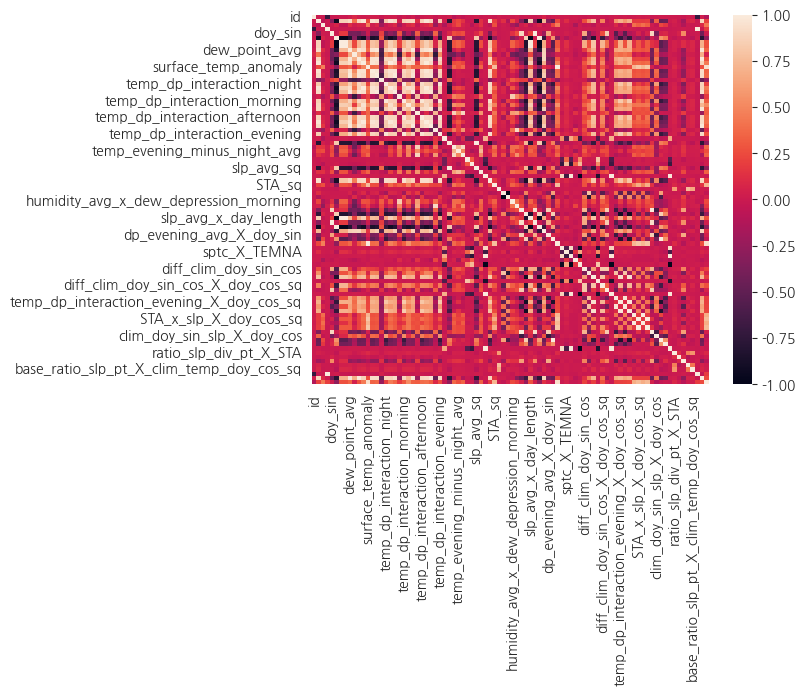

In [3085]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [3086]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)